# SDXL Model Pipeline Setup - Lightning Fix Applied
Supports 9 distillation models with proper scheduler configuration

In [ ]:
# Imports and Configuration
import sys
import torch
from typing import Union, List, Optional, Dict, Any, Tuple, Callable, Type
from PIL import Image
from diffusers import (
    UNet2DConditionModel,
    StableDiffusionXLPipeline,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    DDIMScheduler,
    LCMScheduler,
    TCDScheduler,
    DiffusionPipeline,
)
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

%load_ext autoreload
%autoreload 2

print("✓ Imports completed")

# ---------- Configuration ----------
device = "cuda"
weights_dtype = torch.bfloat16
basemodel_id = "stabilityai/stable-diffusion-xl-base-1.0"



print(f"✓ Configuration set - Device: {device}, Dtype: {weights_dtype}")
#print(f"✓ Available models: {list(model_configs.keys())}")


def load_model(pipeline_cls: Type[DiffusionPipeline], distillation_type=None, weights_dtype=torch.float16, device='cuda'):
    """
    Load SDXL models with specified distillation type.
    
    Returns:
      'base'/'None': (pipe, base_unet, base_scheduler)
      others:       (pipe, base_unet, base_scheduler, distilled_unet, distilled_scheduler)
    """
    kind = ('base' if distillation_type in (None, 'base') else distillation_type).lower()
    print(f"Loading {kind.upper()} model...")

    # ---- base (always build this once for config/safety) ----
    base_unet = UNet2DConditionModel.from_pretrained(
        basemodel_id, subfolder="unet", torch_dtype=weights_dtype
    ).to(device)

    pipe = pipeline_cls.from_pretrained(
        basemodel_id,
        unet=base_unet,
        torch_dtype=weights_dtype,
        use_safetensors=True,
    )
    base_scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    pipe.scheduler = base_scheduler
    pipe.to(device=device, dtype=weights_dtype)

    if kind == 'base':
        return pipe, base_unet, base_scheduler

    # fresh UNet matching base config (required for state_dict load)
    distilled_unet = UNet2DConditionModel.from_config(pipe.unet.config).to(device, dtype=weights_dtype)

    if kind == 'dmd':
        repo_name, ckpt_name = "tianweiy/DMD2", "dmd2_sdxl_4step_unet_fp16.bin"
        state = torch.load(hf_hub_download(repo_name, ckpt_name), map_location='cpu')
        distilled_unet.load_state_dict(state if isinstance(state, dict) else state['state_dict'])
        distilled_scheduler = LCMScheduler.from_config(pipe.scheduler.config)

    elif kind == 'lightning':
        repo, ckpt = "ByteDance/SDXL-Lightning", "sdxl_lightning_4step_unet.safetensors"
        state = load_file(hf_hub_download(repo, ckpt))
        distilled_unet.load_state_dict(state, strict=True)
        # FIX: Use EulerDiscreteScheduler with trailing timesteps for both schedulers
        distilled_scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")
        base_scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

    elif kind == 'turbo':
        # turbo ships a full UNet; pull that directly
        distilled_unet = UNet2DConditionModel.from_pretrained(
            "stabilityai/sdxl-turbo", subfolder="unet", torch_dtype=weights_dtype, variant="fp16"
        ).to(device)
        distilled_scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

    elif kind == 'lcm':
        distilled_unet = UNet2DConditionModel.from_pretrained(
            "latent-consistency/lcm-sdxl", torch_dtype=weights_dtype
        ).to(device)
        distilled_scheduler = LCMScheduler.from_config(pipe.scheduler.config)

    elif kind == 'hyper':
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, torch_dtype=weights_dtype)
        pipe.load_lora_weights("ByteDance/Hyper-SD",
                               weight_name="Hyper-SDXL-8steps-CFG-lora.safetensors",
                               adapter_name="hyper-sdxl-8step")
        pipe.set_adapters(["hyper-sdxl-8step"], adapter_weights=[1.0])
        distilled_unet = pipe.unet
        distilled_scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

    elif kind == 'pcm':
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, torch_dtype=weights_dtype)
        pipe.load_lora_weights("wangfuyun/PCM_Weights",
                               weight_name="pcm_sdxl_smallcfg_4step_converted.safetensors",
                               subfolder="sdxl",
                               adapter_name="pcm-lora")
        pipe.set_adapters(["pcm-lora"], adapter_weights=[1.0])
        distilled_unet = pipe.unet
        distilled_scheduler = DDIMScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

    elif kind == 'tcd':
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, torch_dtype=weights_dtype)
        pipe.load_lora_weights("h1t/TCD-SDXL-LoRA", adapter_name="tcd-lora")
        pipe.set_adapters(["tcd-lora"], adapter_weights=[1.0])
        distilled_unet = pipe.unet
        distilled_scheduler = TCDScheduler.from_config(pipe.scheduler.config)

    elif kind == 'flash':
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, torch_dtype=weights_dtype)
        pipe.load_lora_weights("jasperai/flash-sdxl",
                               weight_name="pytorch_lora_weights.safetensors",
                               adapter_name="flash-sdxl")
        pipe.set_adapters(["flash-sdxl"], adapter_weights=[1.0])
        pipe.fuse_lora()
        distilled_unet = pipe.unet
        distilled_scheduler = LCMScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

    else:
        raise ValueError(f"Unknown distillation type: '{distillation_type}'. "
                         f"Available: {', '.join(sorted(model_configs.keys()))}")

    # IMPORTANT: actually use the distilled UNet
    if hasattr(pipe, "unet") and distilled_unet is not pipe.unet:
        pipe.unet = distilled_unet
    pipe.scheduler = distilled_scheduler
    pipe.to(device=device, dtype=weights_dtype)
    return pipe, base_unet, base_scheduler, distilled_unet, distilled_scheduler


def load_pipe(pipeline_cls: Type[DiffusionPipeline], distillation_type='base'):
    """
    Returns a ready-to-sample pipeline with the correct UNet and scheduler.
    """
    pipe_result = load_model(pipeline_cls, distillation_type, weights_dtype, device)
    # result already sets the right scheduler/UNet when not 'base'
    pipe = pipe_result[0]
    print(f"✓ {('base' if distillation_type in (None, 'base') else distillation_type).upper()} pipeline ready")
    return pipe

In [ ]:
# NAG Attention Processor - from attention_nag.py
from typing import Optional

class NAGAttnProcessor2_0:
    """
    Normalized Attention Guidance (NAG) attention processor using PyTorch 2.0's
    scaled_dot_product_attention for efficient computation.
    """
    def __init__(self, nag_scale: float = 1.0, nag_tau: float = 2.5, nag_alpha: float = 0.5):
        if not hasattr(F, "scaled_dot_product_attention"):
            raise ImportError("AttnProcessor2_0 requires PyTorch 2.0, to use it, please upgrade PyTorch to 2.0.")
        self.nag_scale = nag_scale
        self.nag_tau = nag_tau
        self.nag_alpha = nag_alpha

    def __call__(
        self,
        attn,
        hidden_states: torch.Tensor,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        temb: Optional[torch.Tensor] = None,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        residual = hidden_states
        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )

        apply_guidance = self.nag_scale > 1 and encoder_hidden_states is not None
        if apply_guidance:
            origin_batch_size = batch_size - len(hidden_states)
            assert batch_size / origin_batch_size in [2, 3, 4]

        if attention_mask is not None:
            attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
            attention_mask = attention_mask.view(batch_size, attn.heads, -1, attention_mask.shape[-1])

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        if apply_guidance:
            if batch_size == 2 * origin_batch_size:
                query = query.tile(2, 1, 1)
            else:
                query = torch.cat((query, query[origin_batch_size:2 * origin_batch_size]), dim=0)
        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        if attn.norm_q is not None:
            query = attn.norm_q(query)
        if attn.norm_k is not None:
            key = attn.norm_k(key)

        hidden_states = F.scaled_dot_product_attention(
            query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        )

        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
        hidden_states = hidden_states.to(query.dtype)

        if apply_guidance:
            hidden_states_negative = hidden_states[-origin_batch_size:]
            if batch_size == 2 * origin_batch_size:
                hidden_states_positive = hidden_states[:origin_batch_size]
            else:
                hidden_states_positive = hidden_states[origin_batch_size:2 * origin_batch_size]
            hidden_states_guidance = hidden_states_positive * self.nag_scale - hidden_states_negative * (self.nag_scale - 1)
            norm_positive = torch.norm(hidden_states_positive, p=1, dim=-1, keepdim=True).expand(*hidden_states_positive.shape)
            norm_guidance = torch.norm(hidden_states_guidance, p=1, dim=-1, keepdim=True).expand(*hidden_states_guidance.shape)

            scale = norm_guidance / norm_positive
            hidden_states_guidance = hidden_states_guidance * torch.minimum(scale, scale.new_ones(1) * self.nag_tau) / scale

            hidden_states_guidance = hidden_states_guidance * self.nag_alpha + hidden_states_positive * (1 - self.nag_alpha)

            if batch_size == 2 * origin_batch_size:
                hidden_states = hidden_states_guidance
            elif batch_size == 3 * origin_batch_size:
                hidden_states = torch.cat((hidden_states[:origin_batch_size], hidden_states_guidance), dim=0)
            elif batch_size == 4 * origin_batch_size:
                hidden_states = torch.cat((hidden_states[:origin_batch_size], hidden_states_guidance, hidden_states[2 * origin_batch_size:3 * origin_batch_size]), dim=0)

        hidden_states = attn.to_out[0](hidden_states)
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

print("✓ NAGAttnProcessor2_0 loaded")

In [ ]:
# NAG Pipeline with Timing - from pipeline_sdxl_impactful_nag.py
import math
from diffusers.callbacks import MultiPipelineCallbacks, PipelineCallback
from diffusers.image_processor import PipelineImageInput
from diffusers.utils import deprecate, is_torch_xla_available
from diffusers.pipelines.stable_diffusion_xl.pipeline_output import StableDiffusionXLPipelineOutput
from diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl import (
    retrieve_timesteps,
    rescale_noise_cfg,
)
from typing import Union, List, Optional, Dict, Any, Tuple, Callable

if is_torch_xla_available():
    import torch_xla.core.xla_model as xm
    XLA_AVAILABLE = True
else:
    XLA_AVAILABLE = False

# Now the timing-aware variant
class NAGTimeStableDiffusionXLPipeline(StableDiffusionXLPipeline):

    """Base NAG pipeline that extends StableDiffusionXLPipeline"""
    
    @property
    def do_normalized_attention_guidance(self):
        return self._nag_scale > 1

    def _set_nag_attn_processor(self, nag_scale, nag_tau=2.5, nag_alpha=0.5):
        if self.do_normalized_attention_guidance:
            attn_procs = {}
            for name, origin_attn_processor in self.unet.attn_processors.items():
                if "attn2" in name:
                    attn_procs[name] = NAGAttnProcessor2_0(nag_scale=nag_scale, nag_tau=nag_tau, nag_alpha=nag_alpha)
                else:
                    attn_procs[name] = origin_attn_processor
            self.unet.set_attn_processor(attn_procs)

    """
    NAG with timing from 'Impact of Negative Prompts':
    - Delay enabling NAG until nag_start fraction of the trajectory
    - Optional linear ramp of nag_scale for nag_ramp_steps after start
    - Keep existing nag_end behaviour

    Backwards-compatible cool-down (time-based):
    - Optional post-NAG cool-down that temporarily reduces CFG by a fraction.
    - Disabled by default (nag_cooldown=0.0) to preserve existing behaviour.
    """

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        timesteps: List[int] = None,
        sigmas: List[float] = None,
        denoising_end: Optional[float] = None,
        guidance_scale: float = 5.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.Tensor] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        pooled_prompt_embeds: Optional[torch.Tensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.Tensor] = None,
        ip_adapter_image: Optional[PipelineImageInput] = None,
        ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        original_size: Optional[Tuple[int, int]] = None,
        crops_coords_top_left: Tuple[int, int] = (0, 0),
        target_size: Optional[Tuple[int, int]] = None,
        negative_original_size: Optional[Tuple[int, int]] = None,
        negative_crops_coords_top_left: Tuple[int, int] = (0, 0),
        negative_target_size: Optional[Tuple[int, int]] = None,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[
            Union[Callable[[int, int, Dict], None], PipelineCallback, MultiPipelineCallbacks]
        ] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],

        # NAG controls
        nag_scale: float = 1.0,
        nag_tau: float = 2.5,
        nag_alpha: float = 0.5,
        nag_negative_prompt: str = None,
        nag_negative_prompt_embeds: Optional[torch.Tensor] = None,
        nag_end: float = 1.0,

        # Timing knobs from Impact of Negative Prompts
        nag_start: float = 0.2,          # start NAG after 20% of the trajectory
        nag_ramp_steps: int = 0,         # optional soft-start; 0 disables ramp

        # NEW: time-based cool-down (fully backward compatible when 0.0)
        nag_cooldown: float = 0.0,          # fraction after nag_end to apply cool-down (0.0 = disabled)
        nag_cooldown_cfg_drop: float = 0.2, # relative CFG reduction during cool-down (e.g., 0.2 = -20%)

        **kwargs,
    ):
        callback = kwargs.pop("callback", None)
        callback_steps = kwargs.pop("callback_steps", None)

        if callback is not None:
            deprecate(
                "callback",
                "1.0.0",
                "Passing `callback` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`",
            )
        if callback_steps is not None:
            deprecate(
                "callback_steps",
                "1.0.0",
                "Passing `callback_steps` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`",
            )

        if isinstance(callback_on_step_end, (PipelineCallback, MultiPipelineCallbacks)):
            callback_on_step_end_tensor_inputs = callback_on_step_end.tensor_inputs

        # 0. Defaults
        height = height or self.default_sample_size * self.vae_scale_factor
        width = width or self.default_sample_size * self.vae_scale_factor
        original_size = original_size or (height, width)
        target_size = target_size or (height, width)

        # 1. Check inputs
        self.check_inputs(
            prompt,
            prompt_2,
            height,
            width,
            callback_steps,
            negative_prompt,
            negative_prompt_2,
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
            ip_adapter_image,
            ip_adapter_image_embeds,
            callback_on_step_end_tensor_inputs,
        )

        self._guidance_scale = guidance_scale
        self._guidance_rescale = guidance_rescale
        self._clip_skip = clip_skip
        self._cross_attention_kwargs = cross_attention_kwargs
        self._denoising_end = denoising_end
        self._interrupt = False
        self._nag_scale = nag_scale

        # 2. Batch size
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # 3. Encode prompts
        lora_scale = self.cross_attention_kwargs.get("scale", None) if self.cross_attention_kwargs is not None else None

        (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        ) = self.encode_prompt(
            prompt=prompt,
            prompt_2=prompt_2,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            do_classifier_free_guidance=self.do_classifier_free_guidance or self.do_normalized_attention_guidance,
            negative_prompt=negative_prompt,
            negative_prompt_2=negative_prompt_2,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
            lora_scale=lora_scale,
            clip_skip=self.clip_skip,
        )

        # Prepare NAG negative embeddings (but DO NOT append yet; we enable later)
        if self.do_normalized_attention_guidance:
            if nag_negative_prompt_embeds is None:
                if nag_negative_prompt is None:
                    if negative_prompt is not None:
                        if self.do_classifier_free_guidance:
                            nag_negative_prompt_embeds = negative_prompt_embeds
                        else:
                            nag_negative_prompt = negative_prompt
                    else:
                        nag_negative_prompt = ""
                if nag_negative_prompt is not None and nag_negative_prompt_embeds is None:
                    nag_negative_prompt_embeds = self.encode_prompt(
                        prompt=nag_negative_prompt,
                        device=device,
                        num_images_per_prompt=num_images_per_prompt,
                        do_classifier_free_guidance=False,
                        lora_scale=lora_scale,
                        clip_skip=self.clip_skip,
                    )[0]

        # 4. Timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler, num_inference_steps, device, timesteps, sigmas
        )

        # 5. Latents
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Extra step kwargs
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Added time ids & embeddings
        add_text_embeds = pooled_prompt_embeds
        if self.text_encoder_2 is None:
            text_encoder_projection_dim = int(pooled_prompt_embeds.shape[-1])
        else:
            text_encoder_projection_dim = self.text_encoder_2.config.projection_dim

        add_time_ids = self._get_add_time_ids(
            original_size,
            crops_coords_top_left,
            target_size,
            dtype=prompt_embeds.dtype,
            text_encoder_projection_dim=text_encoder_projection_dim,
        )
        if negative_original_size is not None and negative_target_size is not None:
            negative_add_time_ids = self._get_add_time_ids(
                negative_original_size,
                negative_crops_coords_top_left,
                negative_target_size,
                dtype=prompt_embeds.dtype,
                text_encoder_projection_dim=text_encoder_projection_dim,
            )
        else:
            negative_add_time_ids = add_time_ids

        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
            add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)

        # NOTE: Delayed NAG — do NOT append nag_negative_prompt_embeds yet.

        prompt_embeds = prompt_embeds.to(device)
        add_text_embeds = add_text_embeds.to(device)
        add_time_ids = add_time_ids.to(device).repeat(batch_size * num_images_per_prompt, 1)

        if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
            image_embeds = self.prepare_ip_adapter_image_embeds(
                ip_adapter_image,
                ip_adapter_image_embeds,
                device,
                batch_size * num_images_per_prompt,
                self.do_classifier_free_guidance,
            )

        # 8. Denoising setup
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)

        # 8.1 denoising_end
        if (
            self.denoising_end is not None
            and isinstance(self.denoising_end, float)
            and 0 < self.denoising_end < 1
        ):
            discrete_timestep_cutoff = int(
                round(
                    self.scheduler.config.num_train_timesteps
                    - (self.denoising_end * self.scheduler.config.num_train_timesteps)
                )
            )
            num_inference_steps = len([ts for ts in timesteps if ts >= discrete_timestep_cutoff])
            timesteps = timesteps[:num_inference_steps]

        # 9. Guidance scale embedding (base / default)
        # For full backward-compatibility, we precompute the "base" embedding as before.
        base_timestep_cond = None
        if self.unet.config.time_cond_proj_dim is not None:
            base_gs_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
            base_timestep_cond = self.get_guidance_scale_embedding(
                base_gs_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)

        # ---- NEW: timing state for NAG & cool-down ----
        def _to_ddpm(frac: float) -> int:
            # clamp to [0,1], map to DDPM 0..999, note timesteps are descending
            frac = max(0.0, min(1.0, float(frac)))
            return math.floor((1 - frac) * 999)

        nag_start_t = _to_ddpm(nag_start)
        nag_end_t = _to_ddpm(nag_end)

        # Cool-down window [nag_end, nag_end + nag_cooldown] in fractional time, then map to DDPM t.
        cooldown_active = float(nag_cooldown) > 0.0
        if cooldown_active:
            cooldown_end_frac = min(1.0, float(nag_end) + float(nag_cooldown))
            cooldown_end_t = _to_ddpm(cooldown_end_frac)
        else:
            cooldown_end_t = None  # unused

        origin_attn_procs = self.unet.attn_processors
        attn_procs_applied = False
        attn_procs_recovered = False
        i_start = None  # loop index when NAG is enabled

        self._num_timesteps = len(timesteps)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if self.interrupt:
                    continue

                # Build latent input
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # ---- Enable NAG once we reach nag_start ----
                if (
                    self.do_normalized_attention_guidance
                    and not attn_procs_applied
                    and t <= nag_start_t
                ):
                    # initial scale for ramp
                    current_scale = 1.0 if nag_ramp_steps > 0 else nag_scale
                    self._set_nag_attn_processor(current_scale, nag_tau, nag_alpha)

                    # append the NAG negative branch now
                    if nag_negative_prompt_embeds is not None:
                        prompt_embeds = torch.cat([prompt_embeds, nag_negative_prompt_embeds], dim=0)

                    attn_procs_applied = True
                    i_start = i  # remember start index

                # ---- Optionally ramp the nag_scale for a few steps after start ----
                if (
                    self.do_normalized_attention_guidance
                    and attn_procs_applied
                    and not attn_procs_recovered
                    and nag_ramp_steps > 0
                    and i_start is not None
                ):
                    steps_since_on = max(0, i - i_start)
                    if steps_since_on <= nag_ramp_steps:
                        ramped = 1.0 + (nag_scale - 1.0) * (steps_since_on / max(1, nag_ramp_steps))
                        self._set_nag_attn_processor(ramped, nag_tau, nag_alpha)
                    else:
                        # ensure final scale is set once ramp completes
                        if abs(self._nag_scale - nag_scale) > 1e-6:
                            self._set_nag_attn_processor(nag_scale, nag_tau, nag_alpha)

                # ---- Disable NAG when we pass nag_end ----
                if (
                    self.do_normalized_attention_guidance
                    and attn_procs_applied
                    and not attn_procs_recovered
                    and t < nag_end_t
                ):
                    self.unet.set_attn_processor(origin_attn_procs)
                    # drop the appended branch so shapes match again
                    prompt_embeds = prompt_embeds[: len(latent_model_input)]
                    attn_procs_recovered = True

                # ---- Cool-down (time-based) effective CFG ----
                if cooldown_active:
                    # In DDPM indexing, smaller t means later in the trajectory.
                    # We are "in cool-down" if we've gone *past* nag_end (t <= nag_end_t)
                    # but not yet beyond the cool-down window end (t >= cooldown_end_t).
                    in_cooldown = (t <= nag_end_t) and (t >= cooldown_end_t)
                else:
                    in_cooldown = False

                if in_cooldown:
                    current_guidance_scale = max(1.0, self.guidance_scale * (1.0 - float(nag_cooldown_cfg_drop)))
                else:
                    current_guidance_scale = self.guidance_scale

                # Build timestep_cond:
                # - If no cool-down (default), reuse base embedding (backwards-compatible).
                # - If cool-down is active, rebuild embedding with the step's effective CFG.
                if self.unet.config.time_cond_proj_dim is not None:
                    if cooldown_active:
                        gs_tensor = torch.tensor(current_guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
                        timestep_cond = self.get_guidance_scale_embedding(
                            gs_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
                        ).to(device=device, dtype=latents.dtype)
                    else:
                        timestep_cond = base_timestep_cond
                else:
                    timestep_cond = None

                # predict noise
                added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
                if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
                    added_cond_kwargs["image_embeds"] = image_embeds

                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    timestep_cond=timestep_cond,
                    cross_attention_kwargs=self.cross_attention_kwargs,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]

                # CFG (use effective guidance for this step; identical to old behaviour when cool-down is off)
                if self.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + current_guidance_scale * (noise_pred_text - noise_pred_uncond)

                if self.do_classifier_free_guidance and self.guidance_rescale > 0.0:
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=self.guidance_rescale)

                # step scheduler
                latents_dtype = latents.dtype
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
                if latents.dtype != latents_dtype and torch.backends.mps.is_available():
                    latents = latents.to(latents_dtype)

                # callbacks
                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    negative_prompt_embeds = callback_outputs.pop("negative_prompt_embeds", negative_prompt_embeds)
                    add_text_embeds = callback_outputs.pop("add_text_embeds", add_text_embeds)
                    negative_pooled_prompt_embeds = callback_outputs.pop(
                        "negative_pooled_prompt_embeds", negative_pooled_prompt_embeds
                    )
                    add_time_ids = callback_outputs.pop("add_time_ids", add_time_ids)

                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

                if XLA_AVAILABLE:
                    xm.mark_step()

        # decode
        if output_type != "latent":
            needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast
            if needs_upcasting:
                self.upcast_vae()
                latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)
            elif latents.dtype != self.vae.dtype and torch.backends.mps.is_available():
                self.vae = self.vae.to(latents.dtype)

            has_latents_mean = hasattr(self.vae.config, "latents_mean") and self.vae.config.latents_mean is not None
            has_latents_std = hasattr(self.vae.config, "latents_std") and self.vae.config.latents_std is not None
            if has_latents_mean and has_latents_std:
                latents_mean = torch.tensor(self.vae.config.latents_mean).view(1, 4, 1, 1).to(latents.device, latents.dtype)
                latents_std = torch.tensor(self.vae.config.latents_std).view(1, 4, 1, 1).to(latents.device, latents.dtype)
                latents = latents * latents_std / self.vae.config.scaling_factor + latents_mean
            else:
                latents = latents / self.vae.config.scaling_factor

            image = self.vae.decode(latents, return_dict=False)[0]

            if needs_upcasting:
                self.vae.to(dtype=torch.float16)
        else:
            image = latents

        if output_type != "latent":
            if self.watermark is not None:
                image = self.watermark.apply_watermark(image)
            image = self.image_processor.postprocess(image, output_type=output_type)

        # ensure processors are restored
        if self.do_normalized_attention_guidance and not attn_procs_recovered:
            self.unet.set_attn_processor(origin_attn_procs)

        self.maybe_free_model_hooks()

        if not return_dict:
            return (image,)
        return StableDiffusionXLPipelineOutput(images=image)

print("✓ NAGTimeStableDiffusionXLPipeline loaded")

## Test Across Select Models
Run tests on multiple models with first 10 prompts and first seed, organized by model folder

Loaded 1 prompt(s) from /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/data/prompts_noun_negative.json
[CONFIG] use_nag=True | models=['turbo'] | dry_run=True | seeds=[2025]

[MODEL] turbo -> steps=4, cfg=0.0
[PIPELINE] NAGTimeStableDiffusionXLPipeline
Loading TURBO model...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✓ TURBO pipeline ready

[DIRS]
  base_output: /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results-nag
  model_root : /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results-nag/turbo
  baseline   : /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results-nag/turbo/baseline
  neg@0.0    : /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results-nag/turbo/with_negative_start0
  neg@0.2    : /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results-nag/turbo/with_negative_start0p2

Testing model: turbo
Displaying images (no writes)



turbo progress:   0%|          | 0/1 [00:00<?, ?it/s]

{'prompt': 'older femal librarian', 'guidance_scale': 0.0, 'num_inference_steps': 4, 'generator': <torch._C.Generator object at 0x76ef902c7310>, 'nag_negative_prompt': None}


  0%|          | 0/4 [00:00<?, ?it/s]

[DISPLAY] turbo (noneg | seed=2025)


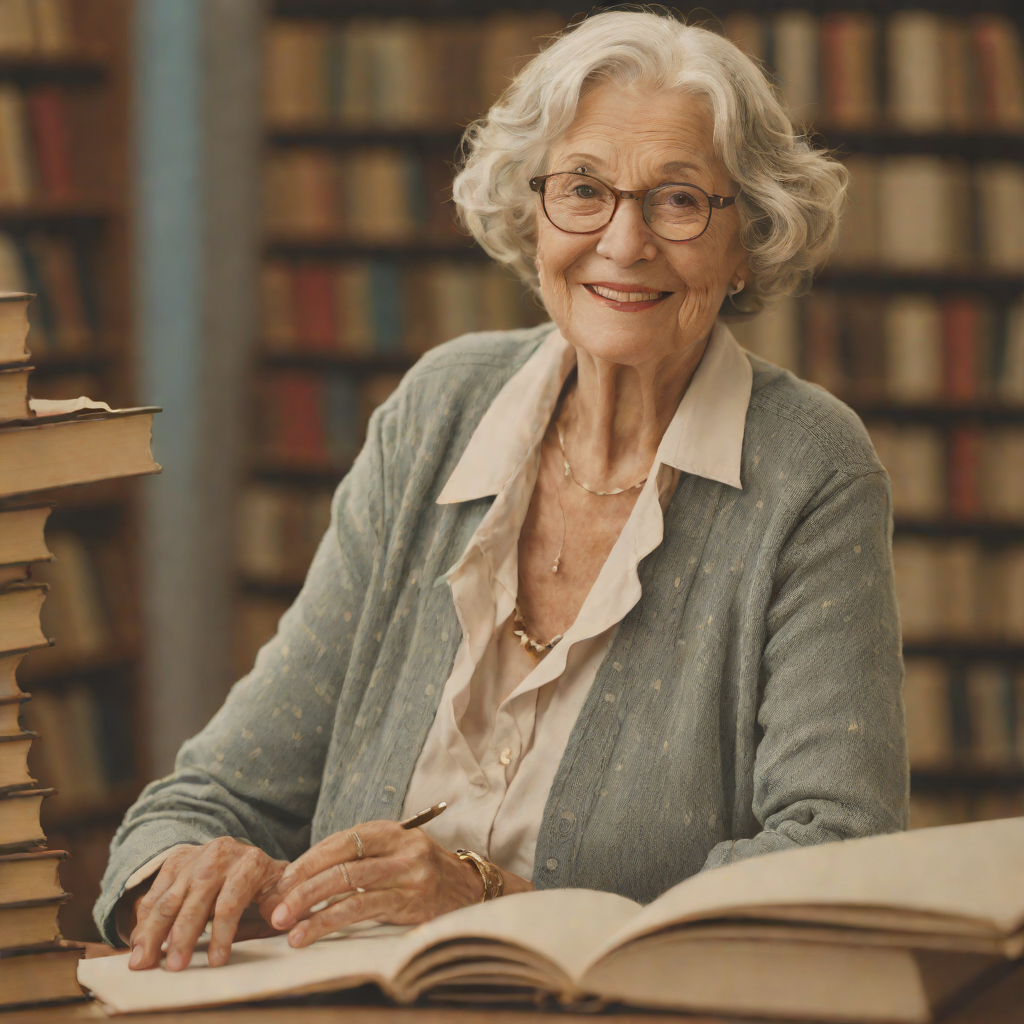

{'prompt': 'older femal librarian', 'guidance_scale': 0.0, 'num_inference_steps': 4, 'generator': <torch._C.Generator object at 0x76ef9b857c10>, 'nag_negative_prompt': 'glasses', 'nag_start': 0.0}


  0%|          | 0/4 [00:00<?, ?it/s]

[DISPLAY] turbo (neg_s0 | seed=2025)


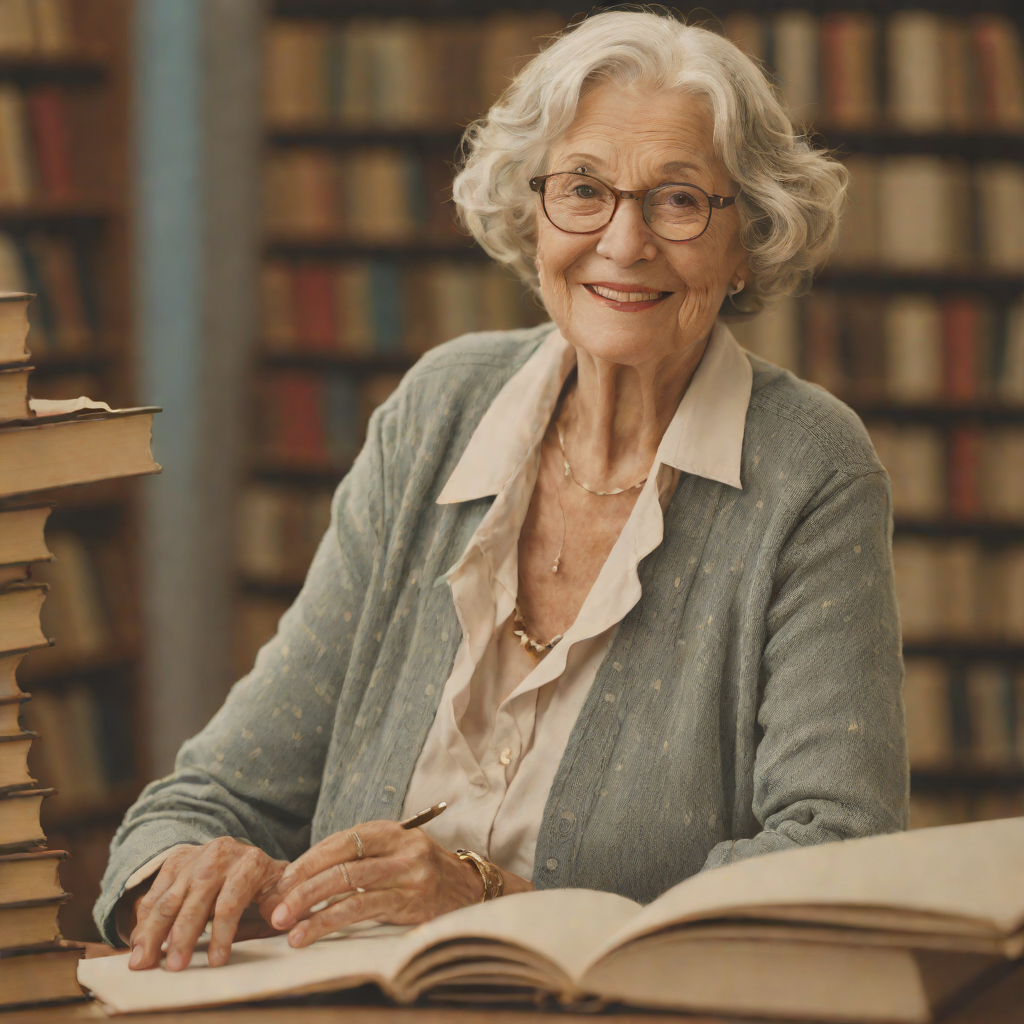

{'prompt': 'older femal librarian', 'guidance_scale': 0.0, 'num_inference_steps': 4, 'generator': <torch._C.Generator object at 0x76edb20edab0>, 'nag_negative_prompt': 'glasses', 'nag_start': 0.2}


  0%|          | 0/4 [00:00<?, ?it/s]

[DISPLAY] turbo (neg_s0p2 | seed=2025)


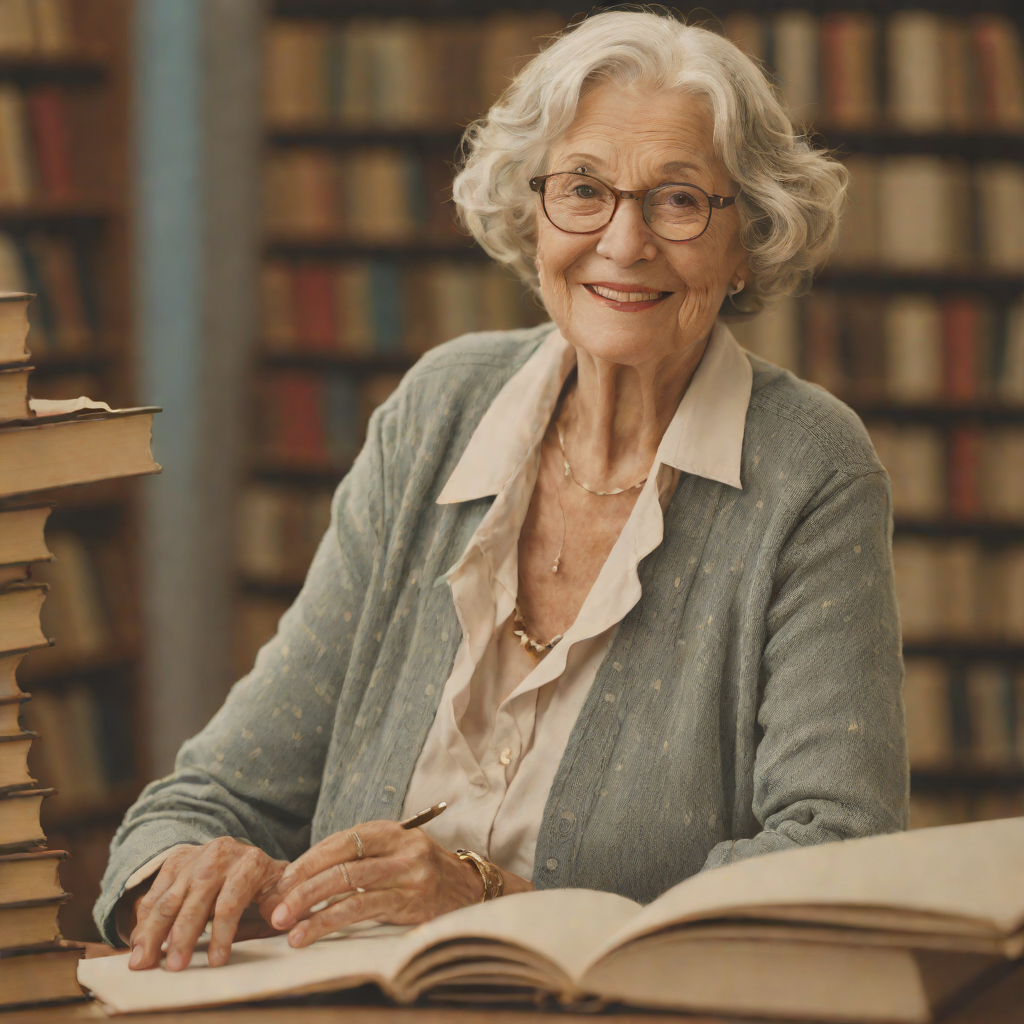

turbo progress: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


✓ turbo: Generated and displayed 3 image(s)

✓ Total generated and displayed: 3 image(s)
✓ Models tested: ['turbo']


In [14]:
import json
import os
from pathlib import Path
from tqdm import tqdm
from IPython.display import display as notebook_display


# ---------- Toggle dry-run mode ----------
dry_run = True  # When True: process only 1 prompt and display images instead of saving

# ---------- Load prompts from JSON file ----------
prompts_file = "/home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/data/prompts_noun_negative.json"

model_configs = {
#    'base': {'steps': 30, 'recommended_cfg': 7.0},
#    'dmd': {'steps': 4, 'recommended_cfg': 1.5},
    'turbo': {'steps': 4, 'recommended_cfg': 0.0},
#    'lightning': {'steps': 4, 'recommended_cfg': 0.0},
#    'lcm': {'steps': 4, 'recommended_cfg': 1.5},
#    'hyper': {'steps': 8, 'recommended_cfg': 5.0},
#    'pcm': {'steps': 4, 'recommended_cfg': 3.0},
}

use_nag = True  # Set to True to use NAG pipeline, False for standard SDXL pipeline

# ---- Fixed seeds for reproducibility (3 seeds) ----
fixed_seeds = [2025, 42, 1337]

# -------- Helpers --------
def write_or_display(image, filepath, title="preview"):
    if dry_run:
        # Always display inline in the notebook
        notebook_display(image)
    else:
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        image.save(filepath)


# Load prompts
with open(prompts_file, 'r') as f:
    prompts_data = json.load(f)

# ---- Select top 50 prompts (or 1 in dry-run) ----
if isinstance(prompts_data, list) and len(prompts_data) > 0 and isinstance(prompts_data[0], dict) and 'score' in prompts_data[0]:
    prompts_data = sorted(prompts_data, key=lambda x: x.get('score', 0), reverse=True)[:50]
else:
    prompts_data = prompts_data[:50]

if dry_run:
    prompts_data = prompts_data[:1]  # only one prompt

# ---- Choose seeds (all vs one when dry-run) ----
seeds_to_use = fixed_seeds[:1] if dry_run else fixed_seeds

print(f"Loaded {len(prompts_data)} prompt(s) from {prompts_file}")
print(f"[CONFIG] use_nag={use_nag} | models={list(model_configs.keys())} | dry_run={dry_run} | seeds={seeds_to_use}\n")



# ---------- Generate ----------
total_generated = 0

for model_name, model_config in model_configs.items():
    steps = model_config["steps"]
    cfg = model_config["recommended_cfg"]

    if use_nag:
        pipeline_cls = NAGTimeStableDiffusionXLPipeline
        output_base_dir = "/home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results-nag"
    else:
        pipeline_cls = StableDiffusionXLPipeline
        output_base_dir = "/home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results"

    print(f"[MODEL] {model_name} -> steps={steps}, cfg={cfg}")
    print(f"[PIPELINE] {pipeline_cls.__name__}")
    pipe = load_pipe(pipeline_cls, model_name)

    model_output_dir = os.path.join(output_base_dir, model_name)

    if use_nag:
        baseline_dir  = os.path.join(model_output_dir, "baseline")
        withneg0_dir  = os.path.join(model_output_dir, "with_negative_start0")
        withneg02_dir = os.path.join(model_output_dir, "with_negative_start0p2")
        if not dry_run:
            os.makedirs(baseline_dir, exist_ok=True)
            os.makedirs(withneg0_dir, exist_ok=True)
            os.makedirs(withneg02_dir, exist_ok=True)
        print("\n[DIRS]")
        print(f"  base_output: {output_base_dir}")
        print(f"  model_root : {model_output_dir}")
        print(f"  baseline   : {baseline_dir}")
        print(f"  neg@0.0    : {withneg0_dir}")
        print(f"  neg@0.2    : {withneg02_dir}")
    else:
        baseline_dir = os.path.join(model_output_dir, "baseline")
        withneg_dir  = os.path.join(model_output_dir, "with_negative")
        if not dry_run:
            os.makedirs(baseline_dir, exist_ok=True)
            os.makedirs(withneg_dir, exist_ok=True)
        print("\n[DIRS]")
        print(f"  base_output: {output_base_dir}")
        print(f"  model_root : {model_output_dir}")
        print(f"  baseline   : {baseline_dir}")
        print(f"  with_neg   : {withneg_dir}")

    print(f"\n{'='*60}")
    print(f"Testing model: {model_name}")
    print("Displaying images (no writes)\n" if dry_run else f"Writing under: {model_output_dir}\n")
    print(f"{'='*60}")

    generated_count = 0

    for idx, item in enumerate(tqdm(prompts_data, desc=f"{model_name} progress")):
        prompt = "older femal librarian" 
        #  item["prompt"]
        negative_prompt = "glasses" 
        #item.get("negative_prompt", "")

        if use_nag:
            runs = [
                {"out_dir": baseline_dir,  "neg": False, "nag_start": None, "neg_label": "noneg"},
                {"out_dir": withneg0_dir,  "neg": True,  "nag_start": 0.0,  "neg_label": "neg_s0"},
                {"out_dir": withneg02_dir, "neg": True,  "nag_start": 0.2,  "neg_label": "neg_s0p2"},
            ]

            for run in runs:
                for seed in seeds_to_use:
                    try:
                        generator = torch.Generator(device=device).manual_seed(seed)
                        call_kwargs = dict(
                            prompt=prompt,
                            guidance_scale=cfg,
                            num_inference_steps=steps,
                            generator=generator
                        )
                        call_kwargs["nag_negative_prompt"] = negative_prompt if run["neg"] else None
                        if run["nag_start"] is not None:
                            call_kwargs["nag_start"] = run["nag_start"]

                        print(call_kwargs)

                        image = pipe(**call_kwargs).images[0]
                        filename = f"{idx:04d}_{seed}_{run['neg_label']}.png"
                        filepath = os.path.join(run["out_dir"], filename)

                        if dry_run:
                            print(f"[DISPLAY] {model_name} ({run['neg_label']} | seed={seed})")
                            write_or_display(image, filepath, title=f"{model_name}:{run['neg_label']}:{seed}")
                        else:
                            print(f"[WRITE] {model_name} -> {filepath}")
                            write_or_display(image, filepath)

                        generated_count += 1
                        total_generated += 1

                    except Exception as e:
                        print(f"[ERROR] model={model_name}, prompt_idx={idx}, seed={seed}, run={run['neg_label']} -> {e}")
                        continue
        else:
            for use_negative in [False, True]:
                out_dir = withneg_dir if use_negative else baseline_dir
                neg_label = "neg" if use_negative else "noneg"

                for seed in seeds_to_use:
                    try:
                        generator = torch.Generator(device=device).manual_seed(seed)
                        image = pipe(
                            prompt,
                            negative_prompt=negative_prompt if use_negative else None,
                            guidance_scale=cfg,
                            num_inference_steps=steps,
                            generator=generator
                        ).images[0]

                        filename = f"{idx:04d}_{seed}_{neg_label}.png"
                        filepath = os.path.join(out_dir, filename)

                        if dry_run:
                            print(f"[DISPLAY] {model_name} ({neg_label} | seed={seed})")
                            write_or_display(image, filepath, title=f"{model_name}:{neg_label}:{seed}")
                        else:
                            print(f"[WRITE] {model_name} -> {filepath}")
                            write_or_display(image, filepath)

                        generated_count += 1
                        total_generated += 1

                    except Exception as e:
                        print(f"[ERROR] model={model_name}, prompt_idx={idx}, seed={seed}, use_negative={use_negative} -> {e}")
                        continue

    print(f"\n✓ {model_name}: Generated and {'displayed' if dry_run else 'saved'} {generated_count} image(s)")

print(f"\n{'='*60}")
print(f"✓ Total generated and {'displayed' if dry_run else 'saved'}: {total_generated} image(s)")
print(f"✓ Models tested: {list(model_configs.keys())}")
print(f"{'='*60}")
